# End-to-End Example #1

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the K-Means model](#Training-the-K-Means-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)


## Introduction

Welcome to our first end-to-end example! Today, we're working through a classification problem, specifically of images of handwritten digits, from zero to nine. Let's imagine that this dataset doesn't have labels, so we don't know for sure what the true answer is. In later examples, we'll show the value of "ground truth", as it's commonly known.

Today, however, we need to get these digits classified without ground truth. A common method for doing this is a set of methods known as "clustering", and in particular, the method that we'll look at today is called k-means clustering. In this method, each point belongs to the cluster with the closest mean, and the data is partitioned into a number of clusters that is specified when framing the problem. In this case, since we know there are 10 clusters, and we have no labeled data (in the way we framed the problem), this is a good fit.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are two parts to this:

1. The role(s) used to give learning and hosting access to your data. Here we extract the role you created earlier for accessing your notebook. See the documentation if you want to specify a different role.
1. The S3 bucket name that you want to use for training and model data. Here we use a default in the form of `sagemaker-{region}-{AWS account ID}`, but you may specify a different one if you wish.

In [1]:
%matplotlib inline

In [2]:
from sagemaker import get_execution_role
from sagemaker.session import Session

role = get_execution_role()
bucket = Session().default_bucket()

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training.  In this case we'll use the MNIST dataset, which contains 70K 28 x 28 pixel images of handwritten digits.  For more details, please see [here](http://yann.lecun.com/exdb/mnist/).

This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [3]:
%%time
import pickle, gzip, numpy, boto3, json

# Load the dataset
region = boto3.Session().region_name
boto3.Session().resource('s3', region_name=region).Bucket('sagemaker-sample-data-{}'.format(region)).download_file('algorithms/kmeans/mnist/mnist.pkl.gz', 'mnist.pkl.gz')
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 1.05 s, sys: 236 ms, total: 1.28 s
Wall time: 1.43 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

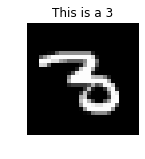

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Training the K-Means model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the k-means training algorithm.  But Amazon SageMaker's k-means has been tested on, and scales well with, multi-terabyte datasets.

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes around 4 minutes.

In [5]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-us-west-2-382932604317/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-us-west-2-382932604317/kmeans_example/output


In [6]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

2020-05-28 19:07:35 Starting - Starting the training job...
2020-05-28 19:07:37 Starting - Launching requested ML instances......
2020-05-28 19:08:45 Starting - Preparing the instances for training.........
2020-05-28 19:10:22 Downloading - Downloading input data
2020-05-28 19:10:22 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/28/2020 19:10:39 INFO 140120511825728] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'ev


2020-05-28 19:10:55 Uploading - Uploading generated training model
2020-05-28 19:10:55 Completed - Training job completed
Training seconds: 98
Billable seconds: 98
CPU times: user 9.19 s, sys: 497 ms, total: 9.69 s
Wall time: 3min 53s


## Set up hosting for the model
Now, we can deploy the model we just trained behind a real-time hosted endpoint.  This next step can take, on average, 7 to 11 minutes to complete.

In [7]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

---------------!CPU times: user 252 ms, sys: 15.6 ms, total: 267 ms
Wall time: 7min 31s


## Validate the model for use
Finally, we'll validate the model for use. Let's generate a classification for a single observation from the trained model using the endpoint we just created.

In [8]:
result = kmeans_predictor.predict(train_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 7.467263221740723
    }
  }
}
]


OK, a single prediction works.

Let's do a whole batch and see how well the clustering works.

In [9]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 23.8 ms, sys: 4.08 ms, total: 27.9 ms
Wall time: 79.2 ms





Cluster 0:


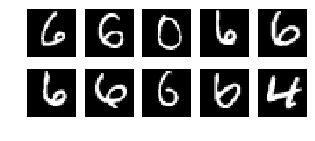




Cluster 1:


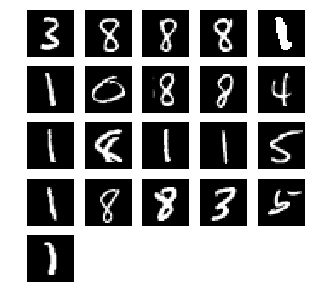




Cluster 2:


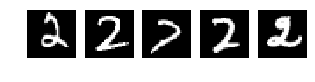




Cluster 3:


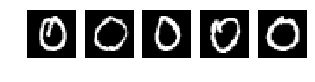




Cluster 4:


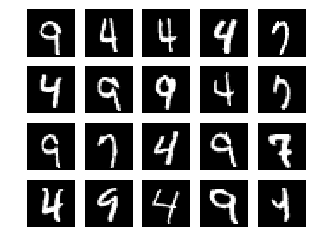




Cluster 5:


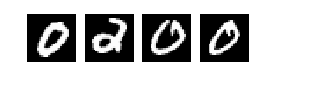




Cluster 6:


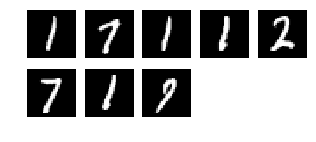




Cluster 7:


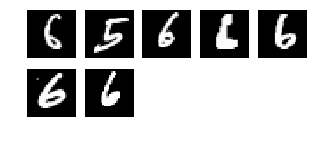




Cluster 8:


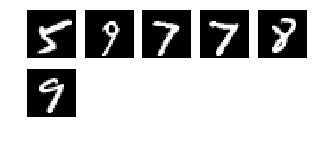




Cluster 9:


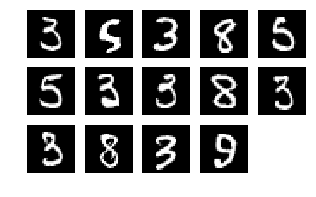

In [10]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

### The bottom line

K-Means clustering is not the best algorithm for image analysis problems, but we do see pretty reasonable clusters being built.

### (Optional) Delete the Endpoint
If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [11]:
print(kmeans_predictor.endpoint)

kmeans-2020-05-28-19-07-35-058


In [12]:
import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)